# Beyond metadata: analytical data search in the cloud with JWST spectral cubes



<span style="color:red"> **WARNING: This notebook is a draft not presently intended for broad public consumption. Feedback is welcome at alucy@stsci.edu.** </span>

For this notebook, we recommend using Fornax with Server Type = "Large - 64GB RAM/16 CPU" and Environment = "Default Astrophysics". As of June 2025, running this notebook once on that server will take about 10 minutes.

## Introduction

As you read through a recent paper by [Assani et al. 2025](https://arxiv.org/pdf/2504.02136), imagine that you find yourself consumed by a single thought:

> I want to find more JWST spectral image cubes containing at least three transitions of Fe II emission from jets launched by young stellar objects (YSOs).

You may now be experiencing some despair. "This observation contains a JWST spectral cube" is certainly something readily available from MAST's metadata tables, but "this file contains Fe II transitions" is certainly not. So instead, you need to dig beyond the metadata and into the data of thousands of files. That may sound difficult, but it can be done!

## Learning goals

The overarching intent of this notebook is to teach you how to use cloud platforms, cloud data access, loading to memory, and Dask parallelization together to answer a complex archival search query that would be difficult to perform without at least some of these tools. We assume that you are running this notebook in the [Fornax science platform](https://nasa-fornax.github.io/fornax-demo-notebooks/documentation/README.html), but it will also still work (in order of preference) in another AWS-based cloud science platform, a non-AWS cloud science platform, and even on your local computer --- perhaps at slower speeds, depending on your computing resources and internet connection.

More granularly, in this notebook you will:

1. Use `astroquery` to ask SIMBAD for all the YSOs it knows about.
2. Use `astroquery` to ask MAST for all JWST spectral cube observations.
3. Use Dask to parallelize a custom function to crossmatch the SIMBAD YSOs to the footprints of MAST observations, making use of all your CPU cores while bypassing an `astroquery` method that would take too long for the large number of targets involved.
4. Learn how to retrieve MAST data from the AWS cloud into memory, and bypass certain roadblocks encountered when dealing with large numbers of data products.
5. Parallelize a set of custom functions to algorithmically analyze thousands of spectral cube data files, and assess which of these are likely to exhibit extended Fe II emission.

## Imports

Pending incorporation of a recent `astroquery` pull request into the version of astroquery installed in the default Fornax kernel, we need to install the latest development version of astroquery. We can suppress the voluminous output here with `%%capture`, which will store the cell's output in a variable `captured` (accessed through `captured.stdout` and `captured.stderr`).

In [1]:
%%capture captured

%pip install git+https://github.com/astropy/astroquery.git

**You may need to restart your kernel now for that to take effect.**

Otherwise, all of the following dependencies are all included in the default Fornax kernel:

In [2]:
# Query databases
from astroquery.simbad import Simbad
from astroquery import mast
from astroquery.ipac.irsa import Irsa

# Crossmatch coordinates to footprint polygons
from matplotlib.path import Path

# Create plots
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

# Wrangle data 
from astropy.table import Table, Column, Row
from astropy.io import fits
import pandas as pd
import numpy as np

# Wrangle units
from astropy.coordinates import SkyCoord
import astropy.units as u

# Detect extended emission in specific wavebins
from scipy.signal import find_peaks
from scipy.ndimage import label
import bisect

# Utility functions
import os
import sys
import copy

# Parallelize
import dask
import dask.dataframe as dd

We'll also need a couple local functions written specifically for this notebook. These are located in the `code_src` directory, and you can read them there. However, they're pretty long, and their detailed implementation isn't critical to understand. As long as you understand their inputs and outputs, which we'll discuss later, you can write better functions to replace them, tailored to your own science case.

In [3]:
# Local code imports
sys.path.append('code_src/')

from extension_vs_wavebin import extension_vs_wavebin
from detect_spikes import detect_spikes

Let's turn on cloud functionalities for `astroquery.mast.Observations`, in case we need them:

In [4]:
mast.Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


Later, we'll be evaluating boolean conditionals on values that could be `None`, the pandas equivalent `pandas.NA`, or a normal value, and we'll also need this little function. It's pretty uninteresting, so let's get it out of the way now!

In [5]:
# Check that x is not None and is not pd.NA
def exists(x):
    try:
        return x is not None and not pd.isna(x)
    except TypeError:
        # For types that can't be checked with pd.isna
        return x is not None

## Part I: Finding JWST spectral cubes of YSOs

Let's ignore the emission line issue and tackle the easiest parts of our driving question first: I want to find more JWST spectral cubes of young stellar objects.

### Querying SIMBAD for YSOs

At this time, MAST doesn't support reliable object classification search. So let's go to the experts in astronomical object cataloging, SIMBAD, which we can access through `astroquery.simbad.Simbad.query_tap`.

In the cell below, we search for all SIMBAD-catalogued objects labeled as YSOs (`otype='Y*O'`) or as any of the descendant sub-concepts of YSOs, like T Tauri stars (`otype='Y*O..'` to retrieve both explicitly labeled YSOs and their subtypes).

In [6]:
# This will take a minute or two.
yso_table = Simbad.query_tap("SELECT * FROM basic WHERE otype='Y*O..'", maxrec=1000000)

In [7]:
print(f'We found {len(yso_table)} YSOs.')

We found 74499 YSOs.


Let's make a list of their sky coordinates:

In [8]:
yso_coords = []  # List of tuples, each tuple a coordinate.
for row in yso_table:
    # Check if the coordinates exist
    if isinstance(row['ra'], float) and isinstance(row['dec'], float):
        # Append the coordinates to the list
        yso_coords.append((row['ra'], row['dec']))
    
print(f'{len(yso_coords)} of these YSOs have good coordinates.')

73692 of these YSOs have good coordinates.


### Querying MAST for all JWST spectral cube observations

Now we want to get all the JWST spectral cube observations in MAST whose sky footprints overlap with any of these YSO coordinates. The natural tool is the `astroquery.mast.Observations` class, which gives programmatic access to MAST's multi-mission archive.

However, `astroquery.mast` is not currently set up to quickly run a multi-target query for tens of thousands of sky coordinates. So in order to get things done in a reasonable amount of time, we need to think about the order of operations here.

It turns out that, at the time of writing, there are only a few tens of thousands of JWST spectral cubes across the whole sky. So let's retrieve *all* of those first, excluding only those with a `calib_level` of `-1` (planned observations that haven't yet executed) and non-public datasets.

In [9]:
# This will typically take anywhere from a few seconds to a minute or so,
# depending on how many people are using MAST right now.
# Rarely, if MAST is overloaded, it may take several minutes or time out.
jwst_obstable = mast.Observations.query_criteria(dataproduct_type='cube',
                                                 obs_collection='JWST',
                                                 dataRights='PUBLIC',  # Limit to public data
                                                 calib_level = [0, 1, 2, 3, 4])  # Exclude planned observations

In [10]:
print(f'We found {len(jwst_obstable)} JWST spectral cube observations.')

We found 22403 JWST spectral cube observations.


`Astroquery` has retrieved a wide variety of metadata for each of these observations. Let's look at the first couple rows:

In [11]:
jwst_obstable[0:2]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str11,str4,str7,str11,str4,str17,str8,str30,str130,str43,float64,float64,str4,str33,int64,float64,float64,float64,float64,float64,str160,float64,str4,str6,int64,str119,str69,str70,str6,bool,float64,str9,str9
science,JWST,CALJWST,MIRI/IFU,JWST,CH4-SHORT,Infrared,LMC-MIRI-FGS-ALIGNMENT,Calibration; Astrometric,jw01171-o001_t001_miri_ch4-short,80.48876249999999,-69.49941666666666,cube,"Hartig, George",3,59682.03122266944,59682.04863098379,1209.916,17700.0,20950.0,SIAF PRD Update (MIRI-FGS Alignment),59774.8541666,1171,COM,--,POLYGON 80.540697116 -69.496797597 80.540697116 -69.493297597 80.551244844 -69.493297597 80.551244844 -69.496797597,mast:JWST/product/jw01171-o001_t001_miri_ch4-short_s3d.jpg,mast:JWST/product/jw01171-o001_t001_miri_ch4-short_s3d.fits,PUBLIC,False,nan,79289259,340881998
science,JWST,CALJWST,MIRI/IFU,JWST,CH4,INFRARED,CENA-NUC,Galaxy; Active galactic nuclei,jw01269-c1000_t001_miri_ch4-shortmediumlong,201.36506291666666,-43.01911388888891,cube,"Luetzgendorf, Nora",3,60022.71489575046,60022.82616263889,3596.4480000000003,17700.0,27900.0,NIRSpec Observations of Centaurus-A: a GTO program proposal,60389.14100692,1269,GTO,--,POLYGON 201.362842098 -43.02120877 201.362842098 -43.017319882 201.367629397 -43.017319882 201.367629397 -43.02120877,mast:JWST/product/jw01269-c1000_t001_miri_ch4-shortmediumlong_s3d.jpg,mast:JWST/product/jw01269-c1000_t001_miri_ch4-shortmediumlong_s3d.fits,PUBLIC,False,nan,217691891,523501932


### Large-scale crossmatching of YSO coordinates to MAST footprints

Now, with that table as our starting point, let's match our YSO coordinates to the sky footprints of all these JWST observations. We already have everything from MAST that we need to do this, so we don't need to run another query. The footprint of an observation is in the `s_region` column of the observations table output by `astroquery`:

In [12]:
# For example...
print(jwst_obstable[0]['s_region'])

POLYGON 80.540697116 -69.496797597 80.540697116 -69.493297597 80.551244844 -69.493297597 80.551244844 -69.496797597


This `s_region` denotes the vertices of a polygon in right ascension and declination. We can make this string more parsable with this function:

In [13]:
def parse_polygon(s_region):
    # Extract coordinates from the s_region string.
    # Note that, as written, this only works if the s_region is a single polygon,
    # which is the case for all JWST cube observations, but not all missions in MAST.
    if 'POLYGON ICRS' in s_region:
        coords = list(map(float, s_region.replace("POLYGON ICRS", "").strip().split()))
    elif 'POLYGON' in s_region:
        coords = list(map(float, s_region.replace("POLYGON", "").strip().split()))

    # Check if the polygon is closed, with the last vertex identical to the first vertex.
    # If not, append a copy of the first vertex to the end of the list.
    if (coords[-2], coords[-1]) != (coords[0], coords[1]):
        coords.append(coords[0])
        coords.append(coords[1])
    
    # Create a numpy array listing a coordinate tuple for each vertex
    coord_array = np.array([(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)])

    return(coord_array)

In [14]:
# For example...
print(parse_polygon(jwst_obstable[0]['s_region']))

[[ 80.54069712 -69.4967976 ]
 [ 80.54069712 -69.4932976 ]
 [ 80.55124484 -69.4932976 ]
 [ 80.55124484 -69.4967976 ]
 [ 80.54069712 -69.4967976 ]]


Now, let's parse our polygons and use `Matplotlib`'s `Path` class to test whether any of our YSO coordinates are in each observation's sky footprint.

Doing this without parallelizing, as in the following cell, would take about 6 or 7 minutes. If you uncomment this cell and open the "Kernel usage" tab to your right while it runs, you'll notice that you're using only a small percentage of the total CPU capacity that you have access to (e.g., less than 10% if you selected the 16-CPU server option when you launched Fornax). Feel free to click the `Interrupt the kernel` stop button on your notebook, because there's a better way!

In [15]:
# yso_jwst_obs = []  # Instantiate a list of observations whose footprints overlap with any of our YSO coordinates.

# for row in jwst_obstable:  # Looping through all JWST spectral cube observations...
#     polygon = parse_polygon(row['s_region'])  # Parse the polygon

#     polygon_path = Path(polygon, closed=True)  # Convert to matplotlib Path
#     is_inside = polygon_path.contains_points(yso_coords).any()  # Test whether any coordinate from yso_coord is inside this observation's polygon
    
#     if is_inside:
#         yso_jwst_obs.append(row)

# yso_jwst_obstable = Table(rows=yso_jwst_obs, names=jwst_obstable.colnames)  # Convert back to an astropy table.

# print(f'We found {len(yso_jwst_obstable)} JWST spectral cube observations whose footprints overlap with YSO coordinates.')

### Parallelizing the footprint crossmatch with dask

That cell would take a long time to run, so let's parallelize this code to save time! First we'll need to define a function that does what we did above, for each observation, so that we can pass this function into our parallelization tool.

In [16]:
def check_points_in_polygon(row, coordinates_to_test):
    # row will be a row of jwst_obstable, representing a single observation.
    # coordinates_to_test will be our list of YSO coordinate tuples.

    # Convert this observation's polygon to a matplotlib Path
    polygon = parse_polygon(row['s_region'])
    polygon_path = Path(polygon, closed=True)

    # Test whether any coordinate from yso_coord is inside this observation's polygon_path.
    # Return the table row if the match is successful,
    # otherwise return an empty row full of NaNs.
    if polygon_path.contains_points(coordinates_to_test).any():
        return row
    else:
        return pd.Series([np.nan] * len(row), index=row.index)    

Dask is a python module for parallelizing your Python code. Let's set it to use multiple CPU cores to make full use of the computational resources we have in Fornax:

In [17]:
dask.config.set(scheduler='processes')

For this task, we've found that it's best to partition the Observations table into about 4 times as many partitions as there are CPU cores that you have access to. With 4 cores, the next cell will take about 4 or 5 minutes, a slight improvement over the non-parallel approach. With 16 cores, it'll take less than 2 minutes.

In [18]:
num_cores = os.cpu_count()
print(f'We have access to {num_cores} cores.')

We have access to 16 cores.


If you examine the `Kernel usage` tab to your right while running this next cell, you'll see that you're now using about 70% of your multi-CPU capacity.

In [19]:
# Convert jwst_table into a partitioned Dask dataframe,
# so that the cores can split the partitions amongst themselves.
jwst_obsddf = dd.from_pandas(jwst_obstable.to_pandas(), npartitions=num_cores*4)  # Adjust npartitions to taste

# Apply the check_point_in_polygon function in parallel.
meta = pd.DataFrame(columns=jwst_obstable.to_pandas().columns)
results = jwst_obsddf.map_partitions(lambda df: df.apply(lambda row: check_points_in_polygon(row, yso_coords), axis=1), meta=meta).compute()

In [20]:
# Remove empty rows, where check_points_in_polygon reached the "else" part of the return statement.
results = results.dropna(how='all')

# Convert back to an astropy table.
yso_jwst_obstable = Table.from_pandas(results)

print(f'We found {len(yso_jwst_obstable)} JWST spectral cube observations whose footprints overlap with YSO coordinates.')

We found 4583 JWST spectral cube observations whose footprints overlap with YSO coordinates.


## Part II: Finding Fe II emission jets

We're looking for a way to identify jets exhibiting Fe II emission, without human intervention and without knowing much about the data quality or target source in each image. Let's first devise our approach by looking at a case example, and then we'll try it out on the full set of YSO JWST spectral cubes.

### Retrieving sample data from AWS

From [Assani et al. 2025](https://arxiv.org/pdf/2504.02136), we know that the YSO called TMC1A features an extended jet with strong Fe II emission. Let's grab its coordinates from SIMBAD...

In [21]:
tmc1a_meta = Simbad.query_object('TMC1A')
tmc1a_ra = float(tmc1a_meta['ra'])  # ICRS RA of TMC1A in degrees
tmc1a_dec = float(tmc1a_meta['dec'])  # ICRS Dec of TMC1A in degrees

...and retrieve its observations from our table of JWST spectral cube observations of YSOs:

In [22]:
tmc1a_jwst = []

# As before...
for row in yso_jwst_obstable:
    polygon = parse_polygon(row['s_region'])
    polygon_path = Path(polygon, closed=True)
    # We'll use matplotlib.Path.contains_point (singular) this time, instead of .contains_points (plural)
    is_inside = polygon_path.contains_point((tmc1a_ra, tmc1a_dec))
    if is_inside:
        tmc1a_jwst.append(row)

# Convert to an astropy Table
tmc1a_jwst_obstable = Table(rows=tmc1a_jwst, names=jwst_obstable.colnames)

print(f'We found {len(tmc1a_jwst_obstable)} JWST spectral cube observations of TMC1A.')

We found 39 JWST spectral cube observations of TMC1A.


Let's get the AWS cloud URIs for these spectral cube files. Downloading files from AWS (via a cloud URI) isn't **always faster** than downloading from MAST's on-premise servers (via a `dataURI` converted into an HTTP URL), even when the destination for your downloads is an AWS cloud platform like Fornax, but importantly AWS is more **robust** for large data downloads. By retrieving files from AWS instead of MAST, you avoid the risk of overwhelming MAST's on-premise servers and causing problems for other users, and the substantial risk that MAST's on-premise servers may be overwhelmed by requests from other users in the moment that you want to get your data. AWS is, we believe, less likely to be overwhelmed.

Regardless, the volume of available astronomical data is growing faster than the MAST archive's capacity to store on-premise and transmit through HTTP links to the on-premise files. For example, the daily downlinked data volume from the Roman Space Telescope will be about 500 times that of HST. So eventually, for some data, cloud downloads are expected to be the only option.

Following usual MAST practice, we'd ordinarily use `astroquery.mast.Observations` to get all individual data products associated with our tabulated observations...

In [23]:
# Get products contained in these observations
tmc1a_jwst_products = mast.Observations.get_product_list(tmc1a_jwst_obstable)

# Filter to select only the high-level spectral cube products ("S3D").
tmc1a_jwst_products_filtered = mast.Observations.filter_products(tmc1a_jwst_products,
                                                                      mrp_only=True,
                                                                      productSubGroupDescription='S3D')

# Let's look at the first couple rows:

tmc1a_jwst_products_filtered[0:2]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str5,str38,str64,str1,str70,str9,str28,str9,str1,str7,str6,str4,str52,int64,str9,str6,int64,str12
90863697,JWST,cube,jw02104-o001_t001_nirspec_g395h-f290lp,exposure/target (L2b/L3): 3D image of spectrum,D,mast:JWST/product/jw02104-o001_t001_nirspec_g395h-f290lp_s3d.fits,SCIENCE,Minimum Recommended Products,S3D,--,CALJWST,1.17.1,2104,jw02104-o001_t001_nirspec_g395h-f290lp_s3d.fits,168540480,90863697,PUBLIC,3,F290LP;G395H
90863734,JWST,cube,jw02104-o001_t001_nirspec_g235h-f170lp,exposure/target (L2b/L3): 3D image of spectrum,D,mast:JWST/product/jw02104-o001_t001_nirspec_g235h-f170lp_s3d.fits,SCIENCE,Minimum Recommended Products,S3D,--,CALJWST,1.17.1,2104,jw02104-o001_t001_nirspec_g235h-f170lp_s3d.fits,178056000,90863734,PUBLIC,3,F170LP;G235H


...and we could feed this table into `astroquery.Observations.get_cloud_uris` to get the corresponding AWS URIs. However, later we're going to have to do this for *thousands* of JWST observations, each of which can have a remarkable number of underlying products. In that case, `astroquery.mast.Observations.get_product_list` would take quite a long time to run.

Luckily, the high-level "s3d" spectral cube products we're interested in are the primary data product of each observation, which means that the MAST URIs for these files are tabulated in the `dataURL` column of the observations table:

In [24]:
# For example:
print(tmc1a_jwst_obstable[0]['dataURL'])

mast:JWST/product/jw02104-o001_t001_nirspec_g395h-f290lp_s3d.fits


So we can save ourselves quite a lot of time by tricking `astroquery.Observations.get_cloud_uri` into thinking our table of observations is actually a table of products. All `astroquery.Observations.get_cloud_uri` actually needs is a column called `dataURI`, so we'll copy the `dataURL` column into a new `dataURI` column in `tmc1a_jwst_table`:

In [25]:
# Sometimes a single letter makes all the difference!
tmc1a_jwst_obstable['dataURI'] = tmc1a_jwst_obstable['dataURL']

Now we can feed our table of observations into `astroquery.mast.Observations.get_cloud_uris`, which will convert each `dataURI` into a cloud URI. By setting `return_uri_map=True`, we'll ensure that we know which observation each cloud URI corresponds to.  The output `cloud_uri_map` is a python dictionary mapping `dataURI` values to cloud URIs.

In [26]:
cloud_uri_map = mast.Observations.get_cloud_uris(tmc1a_jwst_obstable, return_uri_map=True)

For example, we could grab the AWS (cloud) URI corresponding to the first row of the observations table, to test things out:

In [27]:
row_index = 0

cloud_uri = cloud_uri_map[tmc1a_jwst_obstable[row_index]['dataURI']]

print('Cloud URI: ', cloud_uri)

Cloud URI:  s3://stpubdata/jwst/public/jw02104/L3/t/o001/jw02104-o001_t001_nirspec_g395h-f290lp_s3d.fits


But for demonstration purposes in this notebook, we're going to set this URI value manually so that the rest of this example doesn't change when the unpredictable order of the astroquery results changes:

In [28]:
cloud_uri = 's3://stpubdata/jwst/public/jw01290/L3/t/c1021/jw01290-c1021_t016_miri_ch1-short_s3d.fits'

MAST cloud data is in the [Registry of Open Data on AWS](https://registry.opendata.aws/), so it's configured to allow non-credentialed anonymous access. We can load this file into `astropy.fits` by passing in the cloud URI in as if it were a normal URL, but we need to tell `astropy.fits` to access the file anonymously. More information is available [in the astropy documentation](https://docs.astropy.org/en/stable/io/fits/usage/cloud.html).

In [29]:
with fits.open(cloud_uri, cache=False, use_fsspec=True, fsspec_kwargs={"anon": True}) as hdul:
    header = hdul['SCI'].header
    data = hdul['SCI'].data

# Note: we didn't actually need to manually set use_fsspec=True.
# This is turned on by default when using an AWS URI.

# Note: alternatively, instead of using fsspec inside an astropy.fits.open() to handle the cloud connection,
# you could equivalently use the s3fs module explicitly, as follows. Results are typically similar.

# import s3fs
# fs = s3fs.S3FileSystem(anon=True)
# with fs.open(cloud_uri, 'rb') as cloud_file:
#     with fits.open(cloud_file, 'readonly') as hdul:
#         header = hdul['SCI'].header
#         data = hdul['SCI'].data

Remember that you have a limited storage allocation in your Fornax account: 10 GB at the time of writing. In our case, when we analyze the full set of YSOs, we expect to need at least about 100 GB worth of data net across many small ~10 MB files. Thus, it is important that we are using `cache=False` and `use_fsspec=True` (which are the default settings when passing a cloud URI into `astropy.fits`) to load the data into memory (RAM) rather than into storage. This can similarly be enforced for downloads from on-premise HTTP links, if cloud URIs are not available, by explicitly passing both `cache=False` and `use_fsspec=True` into the `open` function.

### Searching for emission lines in spectral cubes

Let's copy down some of the Fe II wavelengths from [Assani et al. 2025](https://arxiv.org/pdf/2504.02136):

In [30]:
feii_wavelengths = [25.988,24.519,17.936,5.340,1.644,1.600,1.257]  # in microns

For the purposes of demonstration, we'll use three functions that together look at a JWST spectral cube file, and aim to characterize whether or not that spectral cube exhibits spatially-extended Fe II emission at each of these transition wavelengths.

Our first function, `extension_vs_wavebin`, measures the number of pixels above some flux threshold in each wavebin of a cube. We imported it earlier from the local `code_src` directory for this notebook, and you can take a look at it there.

That said, you don't need to read through the whole function. You can and almost certainly should replace it with [your personal favorite image segmentation and/or machine learning algorithm](https://ui.adsabs.harvard.edu/abs/2024A%26C....4800838X/abstract).

The important thing to know is that `extension_vs_wavebin()` takes as input a spectral cube as a `numpy.ndarray` (with first axis wavelength), and outputs a 1-dimensional python list of length equal to the number of wavebins, in which each list element corresponds to the size of bright emission or some parameterization of the probability that an extended jet-like feature is seen in that wavebin. If you write your own function that does all that, then it should be possible to integrate into this workflow.

We can test `extension_vs_wavebin` out using the data cube that we've already downloaded into memory:

In [31]:
test_blobs = extension_vs_wavebin(data)

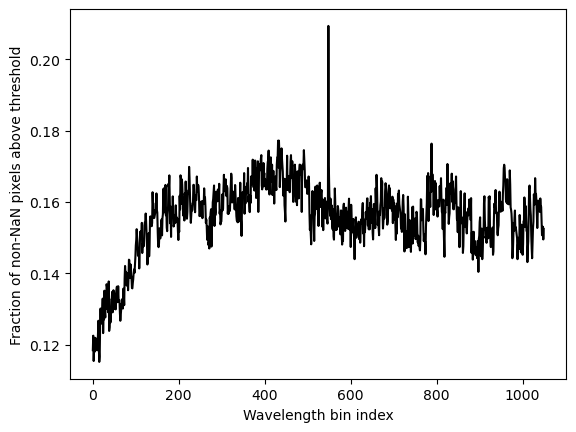

In [32]:
plt.plot(test_blobs, color='k')
plt.xlabel('Wavelength bin index')
plt.ylabel('Fraction of non-NaN pixels above threshold')
plt.show()

We see a variety of messy features, perhaps corresponding to noise or to the brightness of the central star, but we also see a dramatic single-bin spike at around the middle wavebin of the cube. Let's take a look at that slice of the cube, where we see an extended jet emerging from a YSO point source. This is the basis for one of the Fe II line images from Fig. 1 of [Assani et al. 2025](https://arxiv.org/pdf/2504.02136).

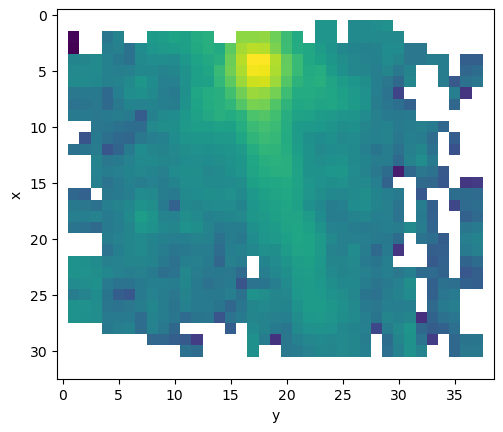

In [33]:
plt.imshow(data[548], norm='log')
plt.xlabel('y')
plt.ylabel('x')
plt.show()

Our next function, `detect_spikes`, was likewise imported earlier from the local `code_src` directory for this notebook, and you can look at it there. It takes as input the 1D list returned by `extension_vs_wavebin`, looks for peaks of extended emission size/probability in the vicinity of a specific wavebin, and returns `True` if and only if a peak is found within 2 wavebins of the input wavebin.

Here again, you can and should substitute your own more sophisticated algorithm. The important things to know are that `detect_spikes` takes the following as input...
- the list returned by `extension_vs_wavebin`,
- an integer wavebin index `pos`,
- an optional float scaling factor `sig` used to set the detection threshold,
- an optional integer `detect_halfwidth` to set the range of wavebins over which the peak finder algorithm is run (defaults to +/-10 pixels, which works well for JWST data),
- and an optional integer `match_halfwidth` to set the distance from `pos` in wavebins that a peak can be found and still count as a match (defaults to +/- 2 pixels)

...and returns `True` if and only if it finds an abrupt increase in extended emission size/probability very close to the specified input wavebin.

For example, `detect_spikes` returns true when we give it the wavebin index with jet emission that we just looked at:

In [34]:
print(detect_spikes(test_blobs, 548, 3.0))

True


And False if we give it an unremarkable wavebin index:

In [35]:
print(detect_spikes(test_blobs, 540, 3.0))

False


Our third and final function serves as a wrapper for our other functions. This is the function that, later, we'll feed directly into a parallelization routine. For each input row (from `tmc1a_jwst_table` in our case), it will check certain metadata to determine if the analysis needs to proceed, then load the spectral cube file into memory, run `extension_vs_wavebin` on the whole data cube, and run `detect_spikes` around the wavebin of each Fe II transition wavelength of interest.

In [36]:
def line_search(row, cloud_uri_map, plot=False):
    
    # Input: row is a row of an astropy table of JWST spectral cube MAST observations -
    # or a pandas Series representing a row of a Dask dataframe.
    # Input: cloud_uri_map parameter is a dictionary mapping the relevant MAST dataURIs to AWS cloud URIs.
    # Input: plot parameter determines whether this function generates summary plots of detected lines on the "blob" spectra.

    # Initialize a list of Fe II jet emission lines detected in this cube:
    detected_feii_lines = []

    # First, let's check some metadata to determine if the analysis needs to proceed for this row.

    # Set condition 1: one of our Fe II wavelengths of interest is in the Observation's spectral range.
    # The cross-mission MAST database that astroquery pulled from gives this range in nanometers.
    condition_1 = any(row['em_min'] <= line*1e3 <= row['em_max'] for line in feii_wavelengths)

    # Set condition 2: check that the data is exists and is accessible in the cloud.
    condition_2 = exists(row['dataURI']) and exists(cloud_uri_map[row['dataURI']])
    
    # Set condition 3: exclude stale observations with the deprecated obs_id pattern '*shortmediumlong*'.
    # These products are no longer available due to a change in the JWST pipeline.
    condition_3 = ('shortmediumlong' not in row['obs_id'])

    # Apply all our database metadata criteria:
    if condition_1 and condition_2 and condition_3:
        
        # Retrieve the Observation's spectral cube data file,
        # and load it directly into memory from the cloud, without downloading a copy to storage.
        cloud_uri = cloud_uri_map[row['dataURI']]
        
        with fits.open(cloud_uri, cache=False, use_fsspec=True, fsspec_kwargs={"anon": True}) as hdul:
            header = hdul['SCI'].header
            data = hdul['SCI'].data

        # Extract the array of wavelengths. Each bin is the wavelength of the corresponding slice of the cube.
        wave = header['CRVAL3'] + header['CDELT3'] * np.arange(header['NAXIS3'])
        # We could use spectral_cube.SpectralCube.read(file, hdu='SCI').spectral_axis, 
        # but spectral_cube reads the whole file into memory, which would increase our resource cost.

        # Let's run our algorithm to look for jet emission in each slice of the cube:
        blobs = extension_vs_wavebin(data)
        # "blobs" contains a list of the sizes (as a fraction of non-NaN pixels in each slice)
        # of contiguous regions ("blobs") of pixels brighter than some threshold in each slice
        # (i.e., at each wavelength).

        for line in feii_wavelengths:  # For each Fe II wavelength of interest...
            if np.min(wave) <= line <= np.max(wave):  # If the Fe II wavelength is within the bounds of this spectral cube...
                 pos = bisect.bisect_left(wave, line)  # Find the approximate wavelength bin index matching the wavelength.
                 detected = detect_spikes(blobs, pos, 3)  # Look for a spike in the blobs array near this wavelength.

                 if detected:  # If we found a spike at this wavelength...
                     # ...then this spectral cube may contain a jet with emission from this Fe+ transition.
                     plt.axvline(x=line, color='r', linestyle='--')
                     detected_feii_lines.append(line)

                 else:  # Otherwise, there's probably not Fe II emission from this line in a jet here.
                     plt.axvline(x=line, color='b', linestyle='--')
            if plot:
                plt.plot(wave, blobs,color='k')

    # If plot=True and at least one Fe II line detected,
    # display the corresponding blob detection plot/
    if plot:
        if len(detected_feii_lines) > 0:
            print('obs_id: ' + row['obs_id'])
            print('Detected lines: ' + str(detected_feii_lines))
            print('Plot:')
            plt.xlabel('Wavelength (microns)')
            plt.ylabel('Fraction of non-NaN pixels above threshold')
            plt.show()

    # Return the input row with a new column holding the detected_feii_lines list
    row['detected_feii_lines'] = detected_feii_lines

    return row

Phew! Let's try this out on our TMC1A observations.

obs_id: jw02104-o001_t001_nirspec_g140h-f100lp
Detected lines: [1.644, 1.6, 1.257]
Plot:


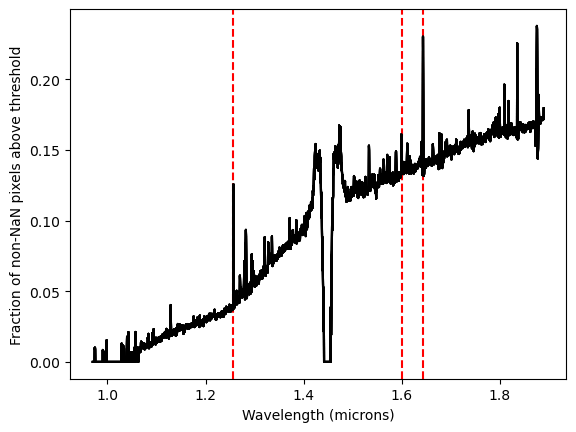

obs_id: jw01290-c1021_t016_miri_ch1-short
Detected lines: [5.34]
Plot:


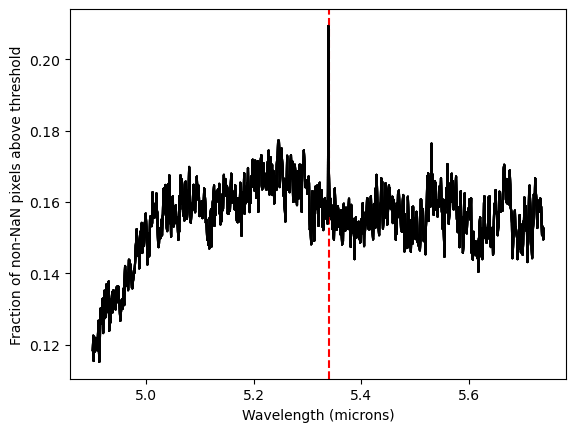

obs_id: jw01290-c1001_t016_miri_ch4-short
Detected lines: [17.936]
Plot:


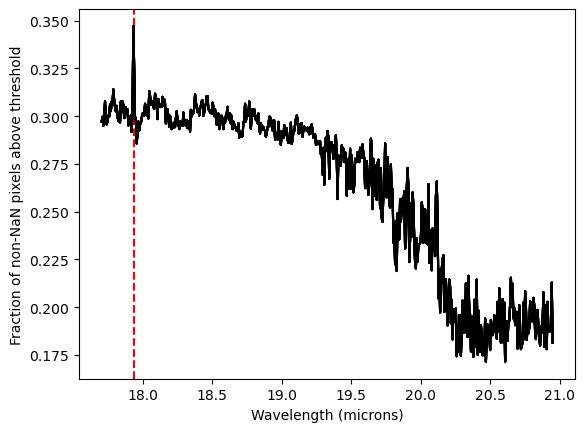

obs_id: jw01290-c1021_t016_miri_ch4-short
Detected lines: [17.936]
Plot:


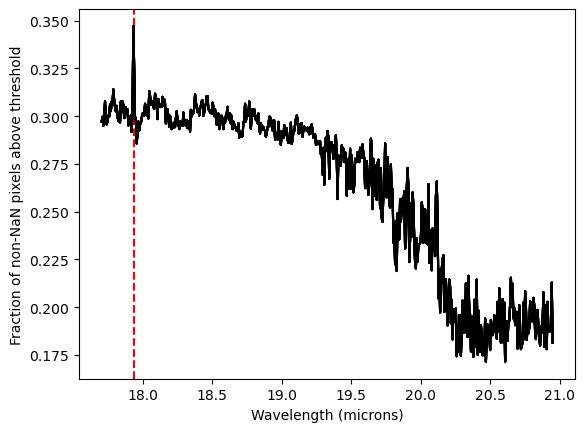

obs_id: jw01290-c1001_t016_miri_ch4-long
Detected lines: [25.988, 24.519]
Plot:


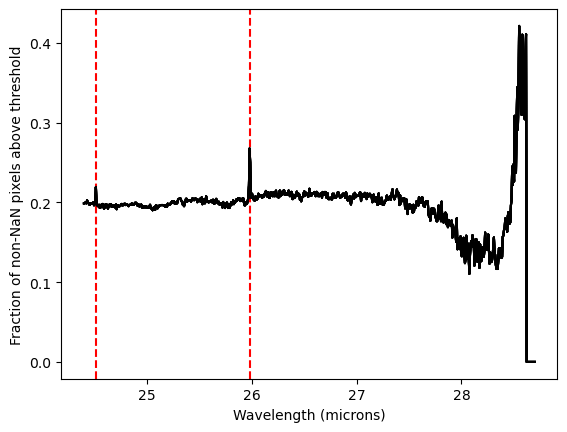

obs_id: jw01290-o014_t016_miri_ch3-long
Detected lines: [17.936]
Plot:


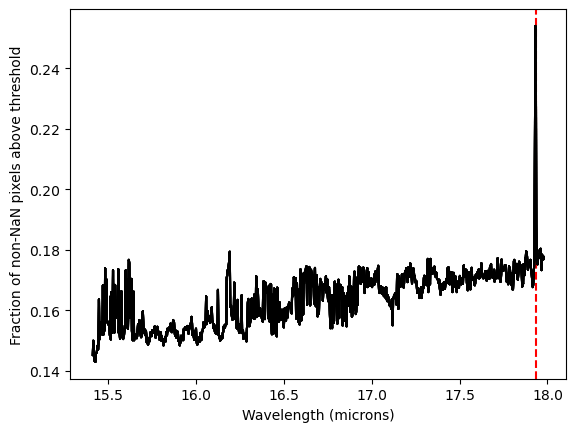

obs_id: jw01290-c1001_t016_miri_ch3-long
Detected lines: [17.936]
Plot:


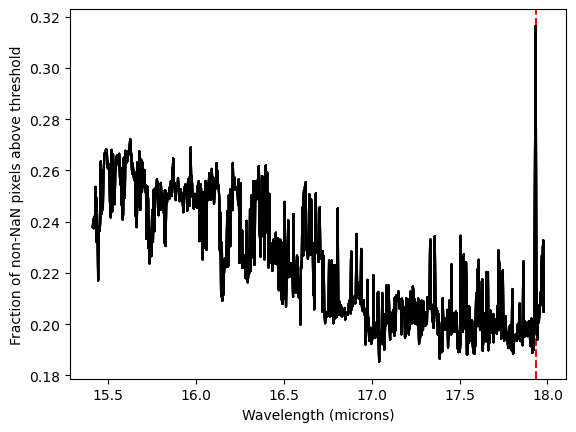

obs_id: jw01290-o014_t016_miri_ch1-short
Detected lines: [5.34]
Plot:


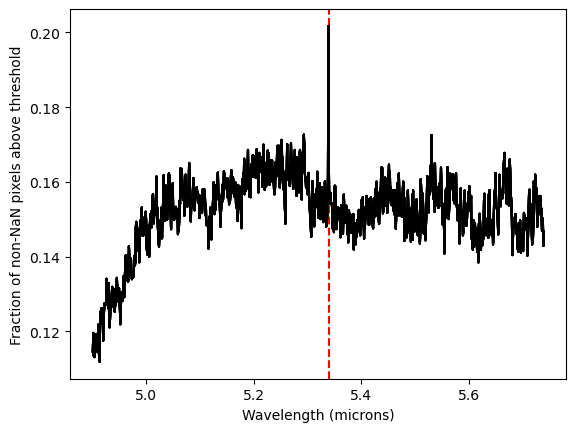

obs_id: jw01290-o014_t016_miri_ch4-long
Detected lines: [25.988]
Plot:


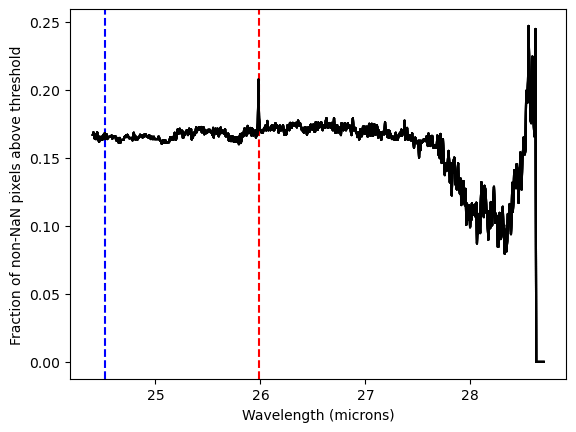

obs_id: jw01290-c1001_t016_miri_ch1-short
Detected lines: [5.34]
Plot:


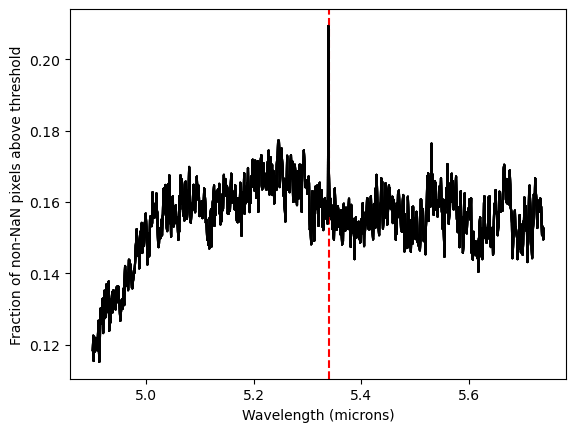

obs_id: jw01290-c1021_t016_miri_ch3-long
Detected lines: [17.936]
Plot:


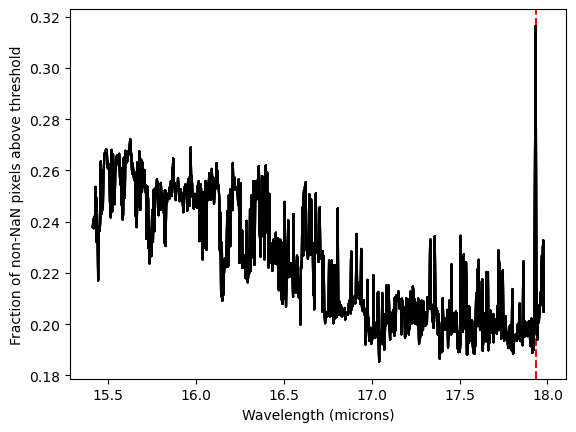

obs_id: jw01290-c1021_t016_miri_ch4-long
Detected lines: [25.988, 24.519]
Plot:


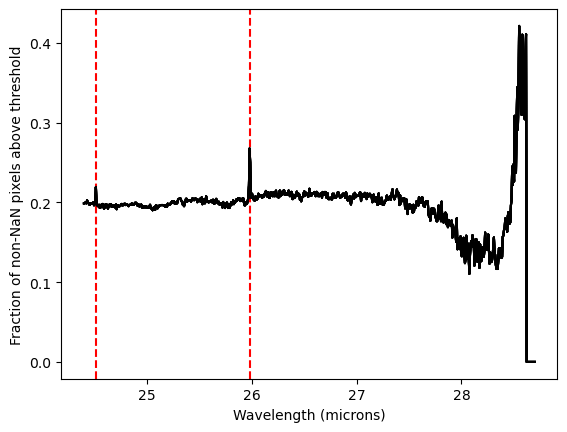

obs_id: jw01290-o014_t016_miri_ch4-short
Detected lines: [17.936]
Plot:


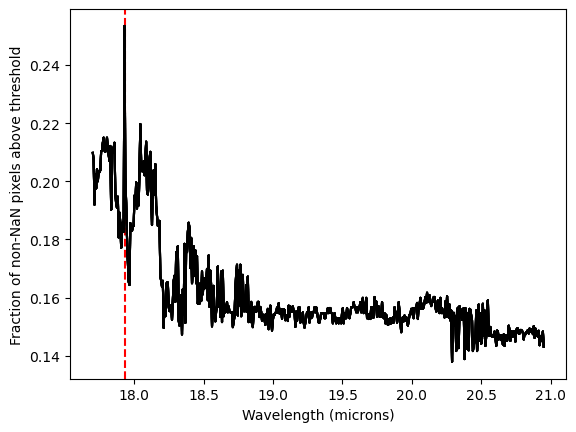

In [37]:
# Make a copy of our observations table with a new column detected_feii_lines to hold results.
copy_tmc1a_jwst_obstable = copy.deepcopy(tmc1a_jwst_obstable)
new_column = Column(name='detected_feii_lines', dtype=object, length=len(tmc1a_jwst_obstable))
copy_tmc1a_jwst_obstable.add_column(new_column)

# Initialize list of astropy table rows to hold results.
lines_tmc1a_jwst = []

# For reach row in our observations table...
for row in copy_tmc1a_jwst_obstable:
    # Execute line_search.
    new_row = line_search(row, cloud_uri_map, plot=True)
    # Append results.
    lines_tmc1a_jwst.append(new_row)

# Convert results list to astropy table.
lines_tmc1a_jwst_obstable = Table(rows=lines_tmc1a_jwst, names=copy_tmc1a_jwst_obstable.colnames)

If we grab all the unique values from inside the python lists tabulated in `lines_tmc1a_jwst_table['detected_feii_lines']`...

In [38]:
all_values = [line for rowlist in lines_tmc1a_jwst_obstable['detected_feii_lines'] for line in rowlist]

detected_lines = set(all_values)

print(detected_lines)

{1.644, 1.257, 1.6, 5.34, 17.936, 24.519, 25.988}


We see that we have reproduced the detection of multiple Fe II lines in the YSO TMC1A.

## Parallelizing the search for emission lines in spectral cubes

Now, for the real test: let's put everything together and apply this technique to the full table of JWST spectral cube observations of SIMBAD-labeled YSOs.

We'll be working with the `yso_jwst_table` of observations:

In [39]:
print(f'We need to look at {len(yso_jwst_obstable)} observations.')

# Let's look at a couple rows:
yso_jwst_obstable[0:2]

We need to look at 4583 observations.


intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str11,str4,str12,str8,str23,str116,str43,float64,float64,str4,str29,float64,float64,float64,float64,float64,float64,str135,float64,str4,str3,object,str119,str69,str70,str6,object,float64,str9,str9
science,JWST,CALJWST,MIRI/IFU,JWST,CH1,INFRARED,HH46IRS-MIRI,Star; Protostars,jw01706-o001_t001_miri_ch1-shortmediumlong,126.4325,-51.00999999999999,cube,"Nisini, Brunella",3.0,60006.53190803981,60006.92109645833,15717.792000000003,4900.0,7650.0,PROJECT-J: PROtostellar JEts Cradle Tested with JWST,60375.849618,1706,GO,--,POLYGON 126.429560324 -51.011708757 126.429560324 -51.007447646 126.436562588 -51.007447646 126.436562588 -51.011708757,mast:JWST/product/jw01706-o001_t001_miri_ch1-shortmediumlong_s3d.jpg,mast:JWST/product/jw01706-o001_t001_miri_ch1-shortmediumlong_s3d.fits,PUBLIC,False,--,118317047,681340981
science,JWST,CALJWST,MIRI/IFU,JWST,CH2,INFRARED,SER-SMM1B,Star; Protostars,jw01290-c1002_t019_miri_ch2-shortmediumlong,277.456675,1.2560833333333334,cube,"Van Dishoeck, Ewine F.",3.0,60209.34135449722,60209.50330913194,599.406,7510.0,11700.0,MIRI EC Protostars Survey,60575.67513878,1290,GTO,--,POLYGON 277.455570475 1.255331425 277.455570475 1.25693698 277.457459818 1.25693698 277.457459818 1.255331425,mast:JWST/product/jw01290-c1002_t019_miri_ch2-shortmediumlong_s3d.jpg,mast:JWST/product/jw01290-c1002_t019_miri_ch2-shortmediumlong_s3d.fits,PUBLIC,False,--,177970829,683347251


As before, let's copy the `dataURL` column into a `dataURI` column:

In [40]:
yso_jwst_obstable['dataURI'] = yso_jwst_obstable['dataURL']

And grab the cloud URIs:

In [41]:
# This will take a minute or so.
cloud_uri_map = mast.Observations.get_cloud_uris(yso_jwst_obstable, return_uri_map=True, verbose=False)

And make a copy of the table with a `detected_feii_lines` column to hold our results:

In [42]:
copy_yso_jwst_obstable = copy.deepcopy(yso_jwst_obstable)
new_column = Column(name='detected_feii_lines', dtype=object, length=len(yso_jwst_obstable))
copy_yso_jwst_obstable.add_column(new_column)

Finally, let's use the Dask parallelizing technique we used before to split `yso_jwst_table` into partitions, and allow our CPUs to split those partitions amongst themselves. You can think of this like sending one spectral cube file to each core, applying `line_search` to the cube, and repeating that until we're done.

In [43]:
yso_jwst_ddf = dd.from_pandas(copy_yso_jwst_obstable.to_pandas(), npartitions=num_cores*4)  # Adjust npartitions to taste
meta = pd.DataFrame(columns=copy_yso_jwst_obstable.to_pandas().columns)

In [44]:
# This will take a few minutes
results = yso_jwst_ddf.map_partitions(lambda df: df.apply(lambda row: line_search(row, cloud_uri_map), axis=1), meta=meta).compute()

In [45]:
# Convert back to an astropy table.
lines_yso_jwst_obstable = Table.from_pandas(results)

# Remove rows where no Fe II lines were detected
# (where detected_feii_lines is an empty list).
lines_yso_jwst_obstable = lines_yso_jwst_obstable[lines_yso_jwst_obstable['detected_feii_lines'].astype(bool)]

print(f'We found {len(lines_yso_jwst_obstable)} JWST spectral cube observations of YSOs that exhibit possible Fe II emission from a candidate jet, narrowed down from an initial {len(jwst_obstable)} JWST spectral cube observations.')

We found 591 JWST spectral cube observations of YSOs that exhibit possible Fe II emission from a candidate jet, narrowed down from an initial 22403 JWST spectral cube observations.


Let's associate each observation to its closest YSO:

In [46]:
# Find the closest coordinates in yso_table for each row in lines_yso_jwst_table

# Drop NaNs from YSO catalog
condition_yso = ~np.isnan(yso_table['ra']) & ~np.isnan(yso_table['dec'])

# Get coordinates from observations table
coords_obs = SkyCoord(ra=lines_yso_jwst_obstable['s_ra'] * u.deg, dec=lines_yso_jwst_obstable['s_dec'] * u.deg)

# Get coordinates from YSO catalog
coords_yso = SkyCoord(ra=yso_table['ra'][condition_yso], dec=yso_table['dec'][condition_yso])

# Get closest matches
idx, d2d, d3d = coords_obs.match_to_catalog_sky(coords_yso)

print(idx.shape)
# idx lists the row indices of yso_table that correspond to each of the observations

(591,)


In [47]:
# Add a column to hold this information
new_column = Column(name='yso_index', data=idx)
lines_yso_jwst_obstable.add_column(new_column)

Now let's find out how many YSOs had at least 3 Fe II emission lines detected:

In [48]:
# Group the observations by YSO
grouped_lines_yso_jwst_obstable = lines_yso_jwst_obstable.group_by('yso_index')

In [49]:
# Instantiate list to hold results
results = []

# For each group of observations (corresponding to a YSO)...
for group in grouped_lines_yso_jwst_obstable.groups:
    # Get all detected Fe II lines for this YSO
    all_values = [line for rowlist in group['detected_feii_lines'] for line in rowlist]
    detected_lines = set(all_values)

    #Count the number of detected Fe II lines for this YSO
    count_lines_detected = len(detected_lines)

    # If at least 3 lines detected for this YSO...
    if count_lines_detected >= 3:
        # Store the YSO index and detected line count in results
        results.append((group['yso_index'][0], count_lines_detected))

In [50]:
print(f'Detected candidate jet emission from at least 3 lines of Fe II in {len(results)} YSOs.')

Detected candidate jet emission from at least 3 lines of Fe II in 52 YSOs.


Let's take a quick look at a random YSO from this list. At the time of writing, this was the `yso_index` value corresponding to the first row of `results`:

In [51]:
# For demonstration purposes, so that the rest of this section knows what data to expect,
# get yso_index corresponding to target_name = 'PER-EMB-33'.
temp_yso_index = max(lines_yso_jwst_obstable['yso_index'][lines_yso_jwst_obstable['target_name']=='PER-EMB-33'])

# Show the first few rows of the observations corresponding to that yso_index
lines_yso_jwst_obstable[lines_yso_jwst_obstable['yso_index']==temp_yso_index][0:3]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,dataURI,detected_feii_lines,yso_index
str7,str4,str7,str11,str4,str12,str8,str23,str116,str43,float64,float64,str4,str29,float64,float64,float64,float64,float64,float64,str135,float64,str4,str3,object,str119,str69,str70,str6,str5,float64,str9,str9,str70,object,int64
science,JWST,CALJWST,MIRI/IFU,JWST,CH3-LONG,INFRARED,PER-EMB-33,Star; Protostars,jw01236-c1003_t003_miri_ch3-long,51.40144166666667,30.75415,cube,"Ressler, Michael E.",3.0,59953.81428518796,59953.90476572917,660.46,15410.0,17980.0,Protostellar Binaries,60319.23930556,1236,GTO,--,POLYGON 51.400122027 30.753363973 51.400122027 30.755252862 51.402578637 30.755252862 51.402578637 30.753363973,mast:JWST/product/jw01236-c1003_t003_miri_ch3-long_s3d.jpg,mast:JWST/product/jw01236-c1003_t003_miri_ch3-long_s3d.fits,PUBLIC,False,--,250928099,741471419,mast:JWST/product/jw01236-c1003_t003_miri_ch3-long_s3d.fits,[17.936],3155
science,JWST,CALJWST,MIRI/IFU,JWST,CH4-LONG,INFRARED,PER-EMB-33,Star; Protostars,jw01236-c1003_t003_miri_ch4-long,51.40144166666667,30.75415,cube,"Ressler, Michael E.",3.0,59953.81428518796,59953.90476572917,660.46,24190.0,27900.0,Protostellar Binaries,60319.23930556,1236,GTO,--,POLYGON 51.399686439 30.75276965 51.399686439 30.755297427 51.402854175 30.755297427 51.402854175 30.75276965,mast:JWST/product/jw01236-c1003_t003_miri_ch4-long_s3d.jpg,mast:JWST/product/jw01236-c1003_t003_miri_ch4-long_s3d.fits,PUBLIC,False,--,250928092,741471372,mast:JWST/product/jw01236-c1003_t003_miri_ch4-long_s3d.fits,"[25.988, 24.519]",3155
science,JWST,CALJWST,MIRI/IFU,JWST,CH3-LONG,INFRARED,PER-EMB-33,Star; Protostars,jw01236-o003_t003_miri_ch3-long,51.40144166666667,30.75415,cube,"Ressler, Michael E.",3.0,59953.81428518796,59953.84576726852,660.46,15410.0,17980.0,Protostellar Binaries,60319.23930556,1236,GTO,--,POLYGON 51.400122027 30.753363973 51.400122027 30.755252862 51.402578637 30.755252862 51.402578637 30.753363973,mast:JWST/product/jw01236-o003_t003_miri_ch3-long_s3d.jpg,mast:JWST/product/jw01236-o003_t003_miri_ch3-long_s3d.fits,PUBLIC,False,--,250928697,741534799,mast:JWST/product/jw01236-o003_t003_miri_ch3-long_s3d.fits,[17.936],3155


We're already familiar with the 5.34 micron line, so let's take a look at that one of the cubes above that contains it:

In [52]:
cloud_uri = cloud_uri_map['mast:JWST/product/jw01236-o003_t003_miri_ch1-short_s3d.fits']

In [53]:
with fits.open(cloud_uri,
               cache=False,
               use_fsspec=True,
               fsspec_kwargs={"anon": True}) as hdul:
    header = hdul['SCI'].header
    data = hdul['SCI'].data

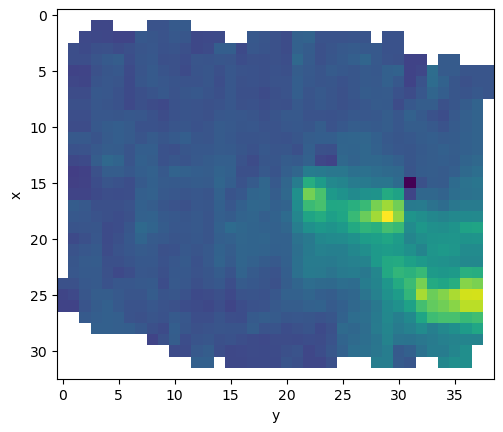

In [54]:
plt.imshow(data[548])  # wavebin 548 for the 5.34 micron line, as before
plt.xlabel('y')
plt.ylabel('x')
plt.show()

Looks promising, at least! Let's check what YSO this is...

In [55]:
yso_table[temp_yso_index]

main_id,nbref,otype,ra,ra_prec,dec,dec_prec,coo_err_maj,coo_err_maj_prec,coo_err_min,coo_err_min_prec,coo_err_angle,coo_qual,coo_wavelength,coo_bibcode,hpx,pmra,pmra_prec,pmdec,pmdec_prec,pm_err_maj,pm_err_maj_prec,pm_err_min,pm_err_min_prec,pm_err_angle,pm_qual,pm_bibcode,plx_value,plx_prec,plx_err,plx_err_prec,plx_qual,plx_bibcode,rvz_type,rvz_radvel,rvz_radvel_prec,rvz_redshift,rvz_redshift_prec,rvz_err,rvz_err_prec,rvz_nature,rvz_qual,rvz_bibcode,vlsr,vlsr_err,vlsr_wavelength,vlsr_bibcode,vlsr_min,vlsr_max,sp_type,sp_qual,sp_bibcode,morph_type,morph_qual,morph_bibcode,galdim_majaxis,galdim_majaxis_prec,galdim_minaxis,galdim_minaxis_prec,galdim_angle,galdim_qual,galdim_wavelength,galdim_bibcode,update_date,oid,otype_txt,rvz_wavelength
,,,deg,,deg,,mas,,mas,,deg,,,,,mas / yr,,mas / yr,,mas / yr,,mas / yr,,deg,,,mas,,mas,,,,,km / s,,,,km / s,,,,,km / s,km / s,,,km / s,km / s,,,,,,,arcmin,,arcmin,,deg,,,,,,,
object,int32,object,float64,int16,float64,int16,float32,int16,float32,int16,int16,str1,str1,object,int64,float64,int16,float64,int16,float32,int16,float32,int16,int16,str1,object,float64,int16,float32,int16,str1,object,str1,float64,int16,float64,int16,float32,int16,object,str1,object,float64,float64,str1,object,float32,float32,object,str1,object,object,str1,object,float32,int16,float32,int16,int16,str1,str1,object,object,int64,object,str1
HH 672,3,HH,37.22166666666667,5,72.6036111111111,5,--,--,--,--,--,D,,2003Ap.....46....1M,994315,--,--,--,--,--,--,--,--,--,,,--,--,--,--,,,,--,--,--,--,--,--,,,,--,--,,,--,--,,,,,,,--,--,--,--,--,,,,2021-05-26,267607,HH,


Ah, it's a Herbig-Haro object! It makes sense that it would exhibit spatially resolved outflows.

Let's take a look at a 5.34 micron slice from each of the other YSOs where we've assessed that there are at least three Fe II lines detected in extended emission, *and* specifically a 5.34 micron line detection. This will take some complicated `matplotlib` wrangling to pack the plots into a grid, but not much else of note.

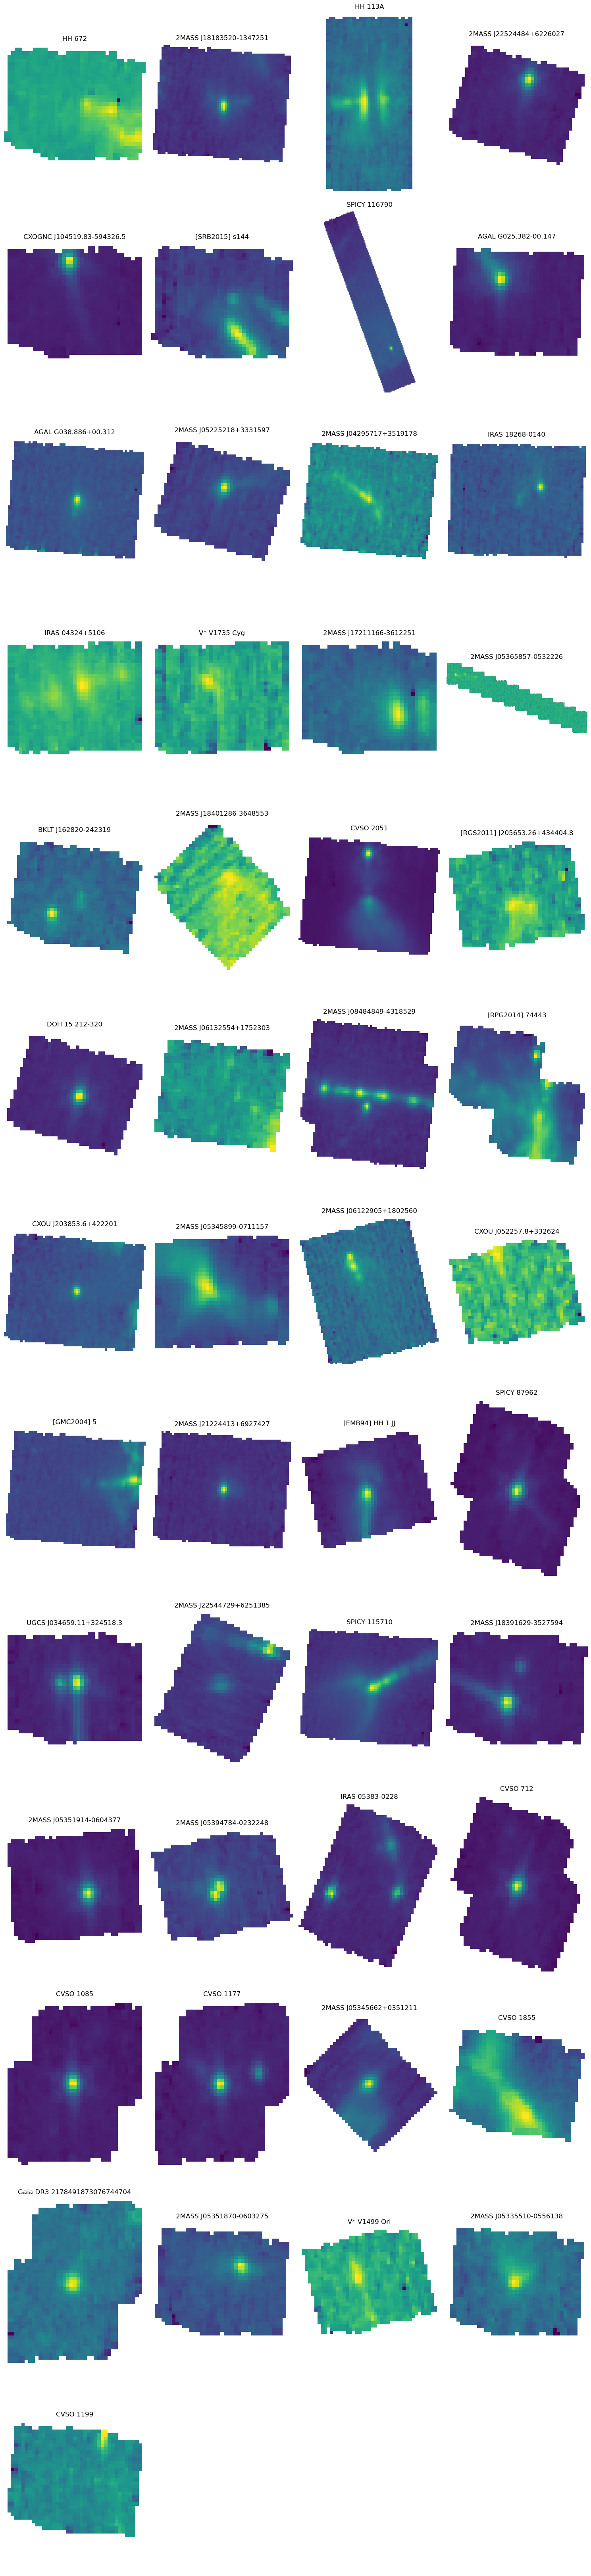

In [56]:
# This cell will take about a minute to run.

# Set up a grid of plots
num_plots = len(results)
cols = 4
rows = (num_plots + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # So that we can index the subplots

i = 0  # instantiate subplot index
# For each YSO meeting our conditions...
for result in results:
    temp_yso_index = result[0]  # Get the yso_index
    yso_name = yso_table['main_id'][temp_yso_index]  # get name from SIMBAD
    # For each observation...
    for row in lines_yso_jwst_obstable:
        #  If this observation contains a detected 5.34 micron slice from this YSO...
        if (row['yso_index'] == temp_yso_index) & (5.34 in row['detected_feii_lines']):
            cloud_uri = cloud_uri_map[row['dataURI']]  # get cloud URI
            # Open the file
            with fits.open(cloud_uri, cache=False, use_fsspec=True, fsspec_kwargs={"anon": True}) as hdul:
                data = hdul['SCI'].data
            # Plot the slice
            axes[i].imshow(data[548], norm=PowerNorm(gamma=0.4))  # wavebin 548 as before
            axes[i].set_title(f'{yso_name}')
            axes[i].axis('off')
            i += 1  # go to next subplot index
            break  # If we got a plot for this YSO, skip to the next YSO

# Turn off unused subplots
for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

At a glance, it looks like we've done a pretty good job of detecting candidate spatially-extended Fe II emission! Further investigation, validation, and improvement are left to the reader as an exercise.

## Postscript: Transposing to IRSA missions

We note that the spectral cubes in [IRSA](https://irsa.ipac.caltech.edu/frontpage/) from Herschel and SOFIA would not be as easy to integrate into this method, largely due to the smaller field of view and the sharp variations in the number of image pixels between adjacent wavebin slices. But with a different set of algorithms in `detect_spikes` and `extension_vs_wavebin`, and a different set of emission lines of interest (say from [Karska et al. 2025](https://arxiv.org/pdf/2503.15059)), it might be possible.

That is left as an *extremely challenging* exercise for the reader, but we'll get you started retrieving spectral cube data for SOFIA...

In [57]:
# Astroquery call
sofia_temp = Irsa.query_sia(facility='SOFIA', calib_level=3, data_type='cube', format='cube/fits')

# Drop rows without footprints
sofia_obstable = sofia_temp[np.array(['POLYGON' in str(region) for region in sofia_temp['s_region']])]

...and crossmatching these footprints to the SIMBAD YSOs:

In [58]:
# Convert jwst_table into a partitioned Dask dataframe,
# so that the cores can split the partitions amongst themselves.
sofia_obsddf = dd.from_pandas(sofia_obstable.to_pandas(), npartitions=num_cores*4)  # Adjust npartitions to taste

# Apply the check_point_in_polygon function in parallel.
meta = pd.DataFrame(columns=sofia_obstable.to_pandas().columns)
results = sofia_obsddf.map_partitions(lambda df: df.apply(lambda row: check_points_in_polygon(row, yso_coords), axis=1), meta=meta).compute()

# Remove empty rows, where check_points_in_polygon reached the "else" part of the return statement.
results = results.dropna(how='all')

# Convert back to an astropy table.
yso_sofia_obstable = Table.from_pandas(results)

In [59]:
# Let's take a look at the first row
yso_sofia_obstable[0]

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
float64,float64,str5,str7,str7,float64,str4,str4,str10,str64,float64,float64,float64,float64,str134,str117,str9,float64,float64,str219,str12,str7,str5,str294,str169,object,str7,str25,str5,str25,str6,object,object,str23,str19,float64,float64,float64,object,float64,float64,float64,object,str142,float64,float64,str1,object,str2,str1,float64
245.54621375762,-50.101311976801554,SOFIA,FIFI-LS,science,3.0,cube,RED,Millimeter,e5c3d6d449d727fab862b56bb1086fc752a747fec469e7039d7e8cd6ed5907fc,--,0.00015773379089567002,0.00015858199411375752,1232.0,Probing Highly Ionized regions in Carina and G333.6-0.2 with [NIII] 57um,https://irsa.ipac.caltech.edu/data/SOFIA/FIFI-LS/L4/p12937/data/g11/F0842_FI_IFS_09002030_RED_WXY_100289-100453.fits,cube/fits,23694.0,3679.468896000001,POLYGON ICRS 245.63640077788904 -50.15960970225613 245.63617719641542 -50.04183211431834 245.45451808376458 -50.04183211431834 245.45429450229096 -50.15960970225613 245.63640077788904 -50.15960970225613,sofia_fifils,science,coadd,"{""AOR_ID"": [""09_0020_30""], ""ASSC_AOR"": [""09_0020_30""], ""ASSC_MSN"": [""2022-03-22_FI_F842""], ""MISSN-ID"": [""2022-03-22_FI_F842""]}","{""INSTCFG"": [""DUAL_CHANNEL""], ""INSTMODE"": [""OTF_TP""], ""SPECTEL1"": [""FIF_BLUE""], ""SPECTEL2"": [""NONE""], ""WAVECENT"": [""57.307""], ""configuration"": [""DUAL_CHANNEL""]}",--,09_0020,Jorge Pineda,SOFIA,G333.6-0.2,object,False,False,"{""OBSTYPE"": [""OBJECT""]}",2019-02-01 00:00:00,105.0,106.0,3.99999999999996,False,59660.20297453704,59660.25532407407,--,--,ivo://irsa.ipac/sofia_fifils?e5c3d6d449d727fab862b56bb1086fc752a747fec469e7039d7e8cd6ed5907fc/F0842_FI_IFS_09002030_RED_WXY_100289-100453.fits,0.11722090573246935,0.0,,--,{},,1.0


Note a few other differences worth keeping in mind:

In [60]:
# Retrieve data through the link in the access_url column
print('HTTP URL: ' + yso_sofia_obstable['access_url'][0])

# or maybe in the future the cloud_access column, though this is not available for SOFIA right now
print('Cloud URI: ' + yso_sofia_obstable['cloud_access'][0])

HTTP URL: https://irsa.ipac.caltech.edu/data/SOFIA/FIFI-LS/L4/p12937/data/g11/F0842_FI_IFS_09002030_RED_WXY_100289-100453.fits
Cloud URI: {}


In [61]:
# em_min and em_max are in meters
print(yso_sofia_obstable['em_min'][0], yso_sofia_obstable['em_max'][0])

0.00015773379089567002 0.00015858199411375752


In [62]:
# The data cubes are in each file's 'FLUX' extension
with fits.open(yso_sofia_obstable['access_url'][0], cache=False, use_fsspec=True) as hdul:
    header = hdul['FLUX'].header
    data = hdul['FLUX'].data

In the future, spectral cubes in IRSA from [the new SPHEREx mission](https://spherex.caltech.edu/page/data-products) might be more readily integrated into the workflow we've demonstrated in this notebook, so stay tuned!

## About this notebook

**Author:**

Adrian Lucy, STScI, alucy@stsci.edu

**Publication date:**

DRAFT

**Citation:**

TBD